Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

import seaborn as sns
sns.set()

from utils.inpainting_utils import *

from BayTorch.freq_to_bayes import MCDropoutVI, MeanFieldVI
from BayTorch.inference.losses import NLLLoss2d
from BayTorch.inference.utils import calc_uncert

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

In [2]:
def np_plot(img):
    if img.shape[0] == 3:
        img = np.moveaxis(img, 0, -1)
    elif img.shape[0] == 1:
        img = img[0]
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()

# Choose figure

In [3]:
img_path  = 'data/inpainting/library.png'
mask_path = 'data/inpainting/library_mask.png'

# Load mask

In [4]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [5]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize

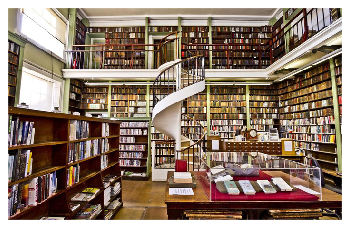

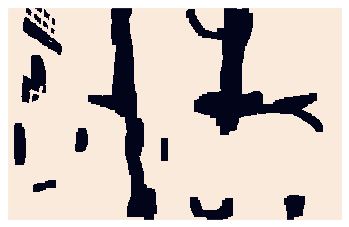

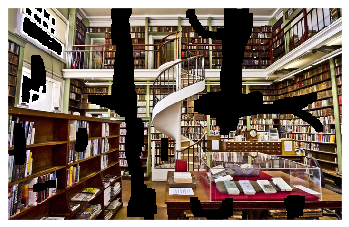

In [6]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

#plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);
np_plot(img_np)
np_plot(img_mask_np)
np_plot(img_mask_np*img_np)

# Setup

In [7]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [8]:
INPUT = 'noise'
input_depth = 1

num_iter = 1001
show_every = 100
figsize = 8
reg_noise_std = 0.00

bay_inf_type = 'mc_dropout'#'mean_field'

        
depth = 6
net = skip(input_depth, img_np.shape[0], 
       num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
       num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
       num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
       filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
       upsample_mode='nearest',
       need1x1_up=False,
       need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

LR = 0.01 
weight_decay = 5e-8

if bay_inf_type == 'mc_dropout':
    net = MCDropoutVI(net, dropout_type='2d', dropout_p=0.1, output_dip_drop=True, deterministic_output=True)
elif bay_inf_type == 'mean_field':
    net = MeanFieldVI(net, prior_scale=1.)

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [9]:
# Compute number of parameters
no_params  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % no_params)

# Loss
mse = torch.nn.MSELoss().type(dtype)
nll = NLLLoss2d()

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 2996467


# Main loop

Starting optimization with ADAM


/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2648: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/TensorIterator.cpp:918.)
  ret = torch._C._nn.mse_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))


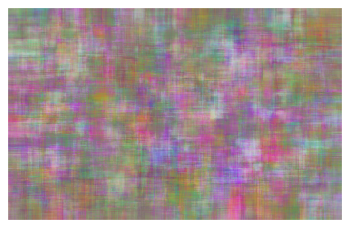

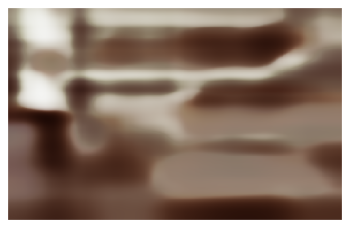

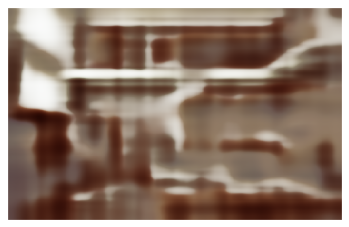

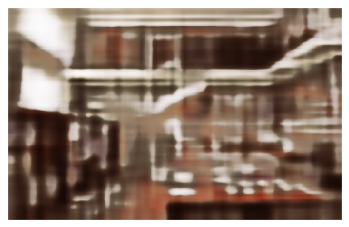

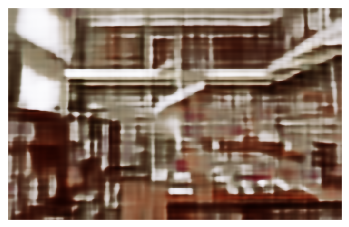

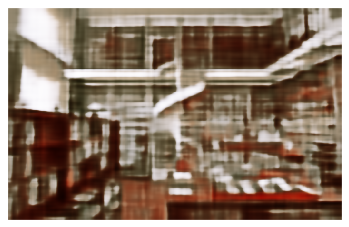

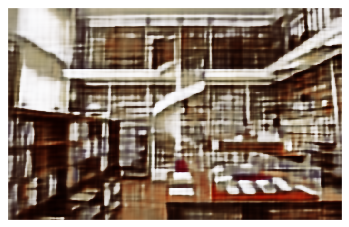

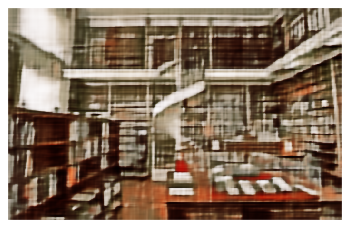

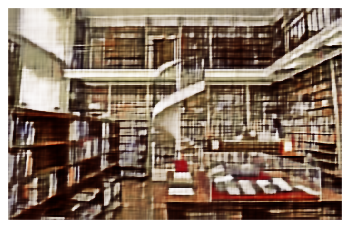

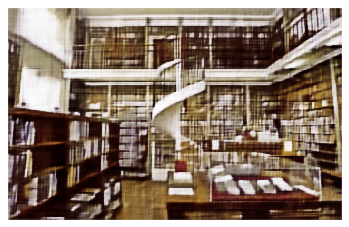

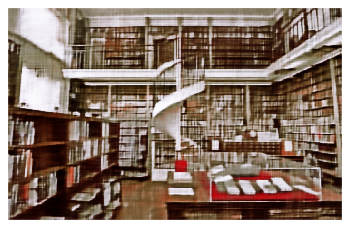

In [10]:
i = 0
def closure():
    
    global i
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)  
        
    out = net(net_input)
    out = torch.sigmoid(out)
    #out[:,:-1] = torch.sigmoid(out[:,:-1])
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    #total_loss = nll(out * mask_var, img_var * mask_var)
    if bay_inf_type == 'mean_field':
        kl = net.kl.type(dtype)
        total_loss += kl * (1/no_params) #beta
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        np_plot(np.clip(out_np, 0, 1))
        #out_mean = np.clip(out_np[:-1], 0, 1)
        #np_plot(out_mean)
        #out_var = np.clip(np.exp(-out_np[-1:]), 0, 1)
        #np_plot(out_var)
        #plot_image_grid([out_mean, out_var], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter, weight_decay)

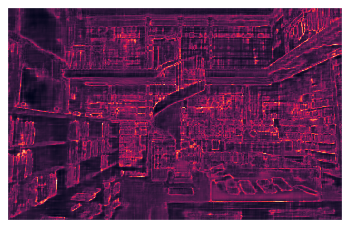

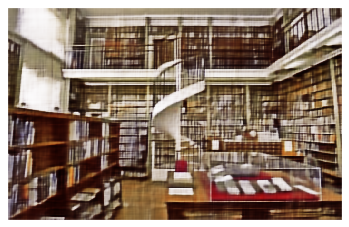

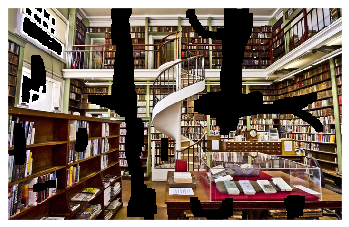

In [20]:
img_list = []
with torch.no_grad():
    for _ in range(20):
        net_input = net_input_saved
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        img = net(net_input)
        img = torch.sigmoid(img)
        #img[:,:-1] = img[:,:-1].sigmoid()
        #img[:,-1:] = torch.exp(-torch.clamp(img[:,-1:], min=-20, max=20))
        img_list.append(img.cpu().numpy()[0])

epi = np.mean(np.std(np.array(img_list), axis=0), axis=0)
#ale, epi, uncert = calc_uncert(img_list, reduction='none')
#out_torch_mean = torch.mean(torch.cat(img_list, dim=0)[:], dim=0, keepdim=True)
out_mean_np = np.mean(np.array(img_list), axis=0)

#np_plot(ale.numpy()[0])
#np_plot(epi.numpy()[0])
#np_plot(uncert.numpy()[0])
#np_plot(out_torch_mean.numpy()[0,:-1])
np_plot(epi)
np_plot(out_mean_np)
np_plot(img_mask_np*img_np)